In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# 1) Upload data

Initially, we acquired the data from FINK using the link provided: https://fink-portal.org/download.

#### Now, let's import the data into Pandas.

In [2]:
pdf = pd.read_parquet('../../ftransfer_ztf_2024-02-01_689626')

In [3]:
pdf.head(2)

,candid,schemavsn,publisher,objectId,candidate,prv_candidates,cutoutScience,cutoutTemplate,cutoutDifference,cdsxmatch,...,fink_broker_version,fink_science_version,timestamp,year,month,day,tnsclass,lc_features_g,lc_features_r,finkclass
0,1356264842615015004,3.3,Fink,ZTF17aaaeclk,"{'aimage': 0.7979999780654907, 'aimagerat': 0....","[{'aimage': 0.75, 'aimagerat': 0.3048779964447...",{'fileName': 'candid1356264842615015004_pid135...,{'fileName': 'candid1356264842615015004_ref.fi...,{'fileName': 'candid1356264842615015004_pid135...,**,...,1.4,0.5.1,2020-09-18 06:21:22.996783,2020,9,18,Unknown,"{'amplitude': 0.8889999389648438, 'anderson_da...","{'amplitude': None, 'anderson_darling_normal':...",**
1,1356465031915010013,3.3,Fink,ZTF17aaarimh,"{'aimage': 0.5720000267028809, 'aimagerat': 0....","[{'aimage': None, 'aimagerat': None, 'bimage':...",{'fileName': 'candid1356465031915010013_pid135...,{'fileName': 'candid1356465031915010013_ref.fi...,{'fileName': 'candid1356465031915010013_pid135...,**,...,1.4,0.5.1,2020-09-18 11:09:38.99808,2020,9,18,Unknown,"{'amplitude': 0.8722000122070312, 'anderson_da...","{'amplitude': 1.0413002967834473, 'anderson_da...",**


#### Here we calculate the first and last days on which an alert was recorded across all the data. 
we're identifying the earliest and latest dates observed across all the alerts in the entire dataset.

In [4]:
jd_series = pdf.candidate.apply(pd.Series)['jd']

last_day = jd_series.max()
# this is not the perfect way to verify the min but we suppose that 'jd' is sorted
first_day = last_day
for k in range(len(pdf)):
    if first_day > pdf.prv_candidates[k][0]['jd']:
        first_day = pdf.prv_candidates[k][0]['jd']

# 

# 2) Select alert and bluid the data Frame

### We select alerts (data) based on their shared ID 

In [6]:
Id = pdf['objectId'][4771]

id_most_repeated = pdf['objectId'].value_counts().idxmax()

# Id = "ZTF18acoyqvk" # max by j (for all Q) here we got = 119 on idx = 13 (all Q matched)
# # Id = "ZTF18abosdhe" #min by j ,  ( idx = 5 , with one Q )

# #Id = "ZTF18adarfuu" # max by Q idx = 6
# Id = "ZTF18aaxyrcb" # min by Q idx = 7
# Id = "ZTF19abizgyw" # <10 data 

# Id = "ZTF18acckcza" # Anomaly data analysis 
# Id = "ZTF18acevrat" # probUpperlim
# Id = "ZTF17aaafgst" # prob stop
# Id = "ZTF17aacezky"
# Id = "ZTF18abhqeds" # no dc_mag ! 
# Id = "ZTF17aaaenex" # ratio 35 we still have upp prob
# Id = "ZTF17aabunxe"
Id = "ZTF17aaaslud" # n r as upper ! 
Id = "ZTF18acevrat" # no valid data !!! (red )\n",
Id = "ZTF20abvtozi" #Sn
# Id = "ZTF18abydczc" # still an upper prob ! 
pdf_filter_by_shared_Id = pdf.loc[pdf['objectId'] == Id]

### Choose the last alert 

In [7]:
candidate_df = pdf_filter_by_shared_Id['candidate'].apply(pd.Series)

candidate_df = candidate_df.sort_values(by= 'jd')
index_max_jd = candidate_df.index[-1]

# select this candidate
pdf_last_alert = pdf_filter_by_shared_Id.loc[index_max_jd]

### Transform the data of all candidates (including `prv_candidates` and the last one) into a DataFrame.

In [8]:
pdf_selec_cands = pdf_last_alert['prv_candidates'] 

In [9]:
#  add 'candidate' the actual value 
keys = pdf_selec_cands[0].keys()
latest_cand = {key: pdf_last_alert['candidate'][key] for key in keys if key in pdf_last_alert['candidate']}

In [10]:
liste_dicts = list(pdf_selec_cands)
liste_dicts.append(latest_cand)
df = pd.DataFrame(liste_dicts)

#

# 3) plot Difference Magnitude in Modified Julian Date [UTC]


_Circles (●) with error bars show valid alerts that pass the Fink quality cuts.
In addition, the Difference magnitude view shows:

_upper triangles with errors (▲), representing alert measurements that do not satisfy Fink quality cuts, but are nevetheless contained in the history of valid alerts and used by classifiers.

_lower triangles (▽), representing 5-sigma magnitude limit in difference image based on PSF-fit photometry contained in the history of valid alerts.

In [11]:
mask1 = (df['rb'] >= 0.55) & (df['nbad'] == 0)
mask2 = (df['rb'] >= 0.55) & (df['nbad'] == 0) & (abs(df['magdiff']) <= 0.1)

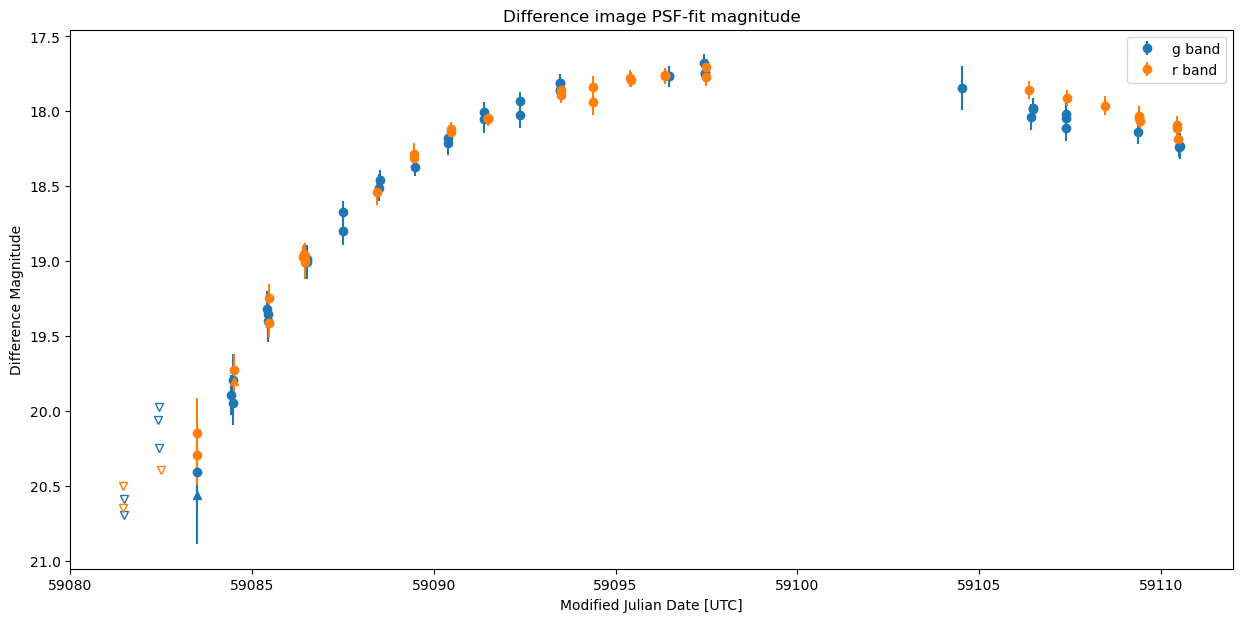

In [12]:
fig = plt.figure(figsize=(15, 7))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

# valid values 
maskValid = (df['rb'] >= 0.55) & (df['nbad'] == 0) #& (abs(df['magdiff']) <= 0.1)# magdiff = magap - magpsf
# Upper limit values
maskUpper = pd.isna(df['magpsf'])
#bad quality values 
maskBadquality = ~maskValid & ~maskUpper

for filt in np.unique(df['fid']):
    maskFilt = df['fid'] == filt

    plt.errorbar(
        df[maskValid & maskFilt]['jd'].apply(lambda x: x - 2400000.5),
        df[maskValid & maskFilt]['magpsf'],
        df[maskValid & maskFilt]['sigmapsf'],
        ls = '', marker='o', color=colordic[filt], label='{} band'.format(filtdic[filt])
    )

    plt.plot(
        df[maskUpper & maskFilt]['jd'].apply(lambda x: x - 2400000.5),
        df[maskUpper & maskFilt]['diffmaglim'],
        ls='', marker='v', color=colordic[filt], markerfacecolor='none'
    )
    

    plt.errorbar(
        df[maskBadquality & maskFilt]['jd'].apply(lambda x: x - 2400000.5),
        df[maskBadquality & maskFilt]['magpsf'],
        df[maskBadquality & maskFilt]['sigmapsf'],
        ls='', marker='^', color=colordic[filt]
    )
    

# plt.ylim(14, 18)
# plt.xlim(59084, 590867)
plt.gca().invert_yaxis()
plt.legend()
plt.title('Difference image PSF-fit magnitude')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Difference Magnitude');


# Plot the magnitude difference for valid data.

Distinguishing between positive differences represented by circles and negative differences represented by triangles.

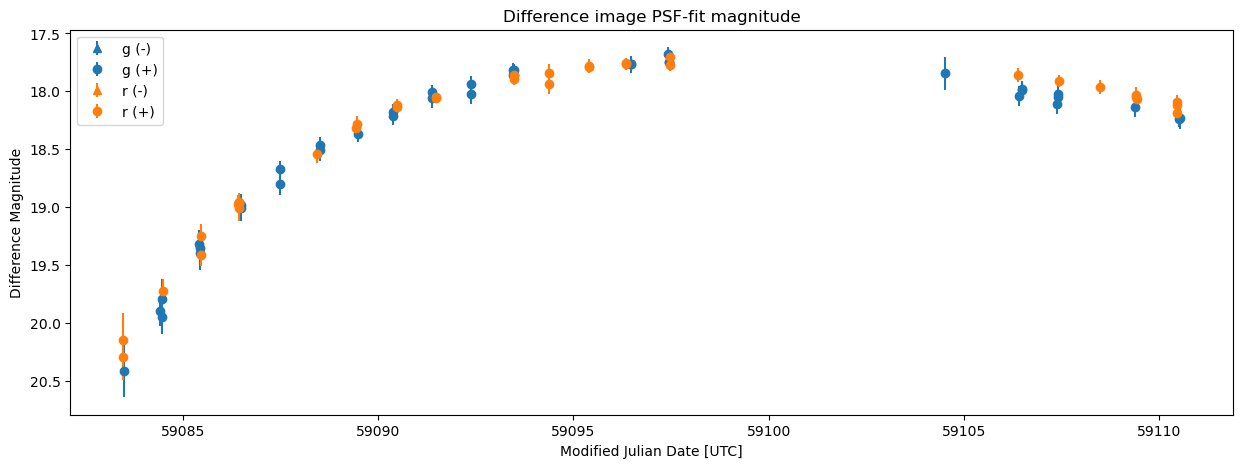

In [13]:
fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}
    
maskValid = (df['rb'] >= 0.55) & (df['nbad'] == 0)

    
#t or 1 => candidate is from positive (sci minus ref) subtraction;
#f or 0 => candidate is from negative (ref minus sci) subtraction"
maskpos = (df['isdiffpos'] == 't') | (df['isdiffpos'] == '1')
maskneg = (df['isdiffpos'] == 'f') | (df['isdiffpos'] == '0')

for filt in np.unique(df['fid']):
    maskFilt = df['fid'] == filt

    # candidates from negative 

    plt.errorbar(
        df[maskValid & maskFilt & maskneg ]['jd'].apply(lambda x: x - 2400000.5),
        df[maskValid & maskFilt & maskneg ]['magpsf'],
        df[maskValid & maskFilt & maskneg ]['sigmapsf'],
        ls = '', marker='^', color=colordic[filt], label='{} (-)'.format(filtdic[filt])
    )
    
    # candidates from positive 
    plt.errorbar(
        df[maskValid & maskFilt &  maskpos ]['jd'].apply(lambda x: x - 2400000.5),
        df[maskValid & maskFilt &  maskpos ]['magpsf'],
        df[maskValid & maskFilt &  maskpos ]['sigmapsf'],
        ls = '', marker='o', color=colordic[filt], label='{} (+)'.format(filtdic[filt])
    )
    

#plt.ylim(12, 22)
plt.gca().invert_yaxis()
plt.legend()
plt.title('Difference image PSF-fit magnitude')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Difference Magnitude');



# 

# 

# 5) Calculate and plot Apparent DC flux  

We utilize a function(`apparent_flux`) located within the `fink_utils` package to compute the apparent flux for the valid data.

In [14]:
from typing import Tuple
def apparent_flux_New(
    magpsf: float,
    sigmapsf: float,
    magnr: float,
    sigmagnr: float,
    isdiffpos: int,    
    is_Source: bool = True,
    jansky: bool = True

) -> Tuple[float, float]:
    """Compute apparent flux from difference magnitude supplied by ZTF
    Implemented according to p.107 of the ZTF Science Data System Explanatory Supplement
    https://irsa.ipac.caltech.edu/data/ZTF/docs/ztf_explanatory_supplement.pdf

    Parameters
    ---------
    magpsf,sigmapsf; floats
        magnitude from PSF-fit photometry, and 1-sigma error
    magnr,sigmagnr: floats
        magnitude of nearest source in reference image PSF-catalog
        within 30 arcsec and 1-sigma error
    isdiffpos: str
        t or 1 => candidate is from positive (sci minus ref) subtraction;
        f or 0 => candidate is from negative (ref minus sci) subtraction
    jansky: bool
        If True, normalise units to Jansky. Default is True.

    Returns
    --------
    dc_flux: float
        Apparent flux
    dc_sigflux: float
        Error on apparent flux
    """
    if magpsf is None or magnr < 0:
        return float("Nan"), float("Nan")
    
    

    difference_flux = 10 ** (-0.4 * magpsf)
    difference_sigflux = (sigmapsf / 1.0857) * difference_flux

    if is_Source: 

        ref_flux = 10 ** (-0.4 * magnr)
        ref_sigflux = (sigmagnr / 1.0857) * ref_flux

        # add or subract difference flux based on isdiffpos
        if (isdiffpos == 't') or (isdiffpos == '1'):
            dc_flux = ref_flux + difference_flux
        else:
            dc_flux = ref_flux - difference_flux

        # assumes errors are independent. Maybe too conservative.
        dc_sigflux = np.sqrt(difference_sigflux**2 + ref_sigflux**2)
        
    else:
        dc_flux= difference_flux
        dc_sigflux = difference_sigflux
        
        
    if jansky:
        dc_flux *= 3631
        dc_sigflux *= 3631

    return dc_flux, dc_sigflux
    
    
    

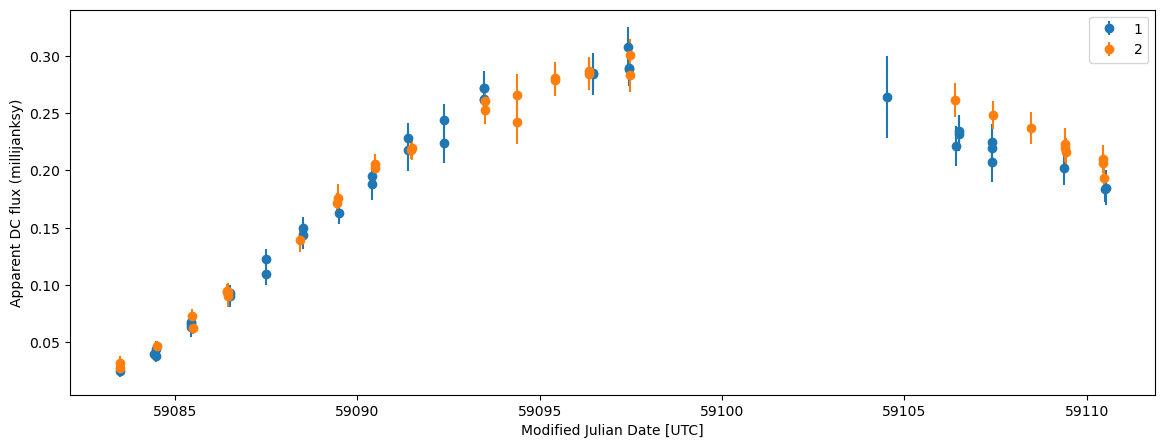

In [15]:
fig = plt.figure(figsize=(14, 5))
from fink_utils.photometry.utils import is_source_behind

# from fink_utils.photometry.conversion import apparent_flux


# Take only valid measurements
maskValid = (df['rb'] >= 0.55) & (df['nbad'] == 0)
df_valid = df[maskValid].sort_values('jd')
df_valid['is_Source'] = is_source_behind(df_valid['distnr'])

# dc_flux, dc_sigflux = np.transpose(
#         [
#             apparent_flux(*args, jansky=True) for args in zip(
#                 df_valid['magpsf'].astype(float).values,
#                 df_valid['sigmapsf'].astype(float).values,
#                 df_valid['magnr'].astype(float).values,
#                 df_valid['sigmagnr'].astype(float).values,
#                 df_valid['isdiffpos'].values
#             )
#         ]
# )

# df_valid['dc_flux_origin'] = dc_flux

# df_valid['dc_sigflux_origin'] = dc_sigflux

dc_flux, dc_sigflux = np.transpose(
        [
            apparent_flux_New(*args, jansky=True) for args in zip(
                df_valid['magpsf'].astype(float).values,
                df_valid['sigmapsf'].astype(float).values,
                df_valid['magnr'].astype(float).values,
                df_valid['sigmagnr'].astype(float).values,
                df_valid['isdiffpos'].values,
                df_valid['is_Source'].astype(bool).values

            )
        ]
)

df_valid['dc_flux'] = dc_flux
df_valid['dc_sigflux'] = dc_sigflux



for filt in np.unique(df['fid']):
    mask = df_valid['fid'] == filt
    sub = df_valid[mask]
    plt.errorbar(
        sub['jd'].apply(lambda x: x - 2400000.5),
        sub['dc_flux']*1e3,
        sub['dc_sigflux']*1e3,
        ls='', 
        marker='o',
        label=str(filt)
    )
plt.legend()

plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Apparent DC flux (millijanksy)');


## Apparent flux for the nearest source

We create a function `flux_nr` to determine the apparent flux for the nearest source in the reference image.

Please don't overlook downloading the FAnomAly package.

In [16]:
from FAnomAly.flux import flux_nr

nr_flux, nr_sigflux = np.transpose(
        [
            flux_nr(*args, jansky=True) for args in zip(
                df_valid['magnr'].astype(float).values,
                df_valid['sigmagnr'].astype(float).values
            )
        ]
)

df_valid['nr_flux'] = nr_flux
df_valid['nr_sigflux'] = nr_sigflux


# 

# 

# 

# 4) Verify whether there is a source behind the object.

If so, we compute the magnitude DC using the new `dc_mag` function.

 And we extract a subset of validated data into a dataframe for further analysis

In [17]:
# from FAnomAly.dc_mag import dc_mag
# from fink_utils.photometry.conversion import dc_mag



# mag_dc, err_dc = np.transpose(
#     [
#         dc_mag(*args) for args in zip(
#             df_valid['magpsf'].astype(float).values,
#             df_valid['sigmapsf'].astype(float).values,
#             df_valid['magnr'].astype(float).values,
#             df_valid['sigmagnr'].astype(float).values,
#             df_valid['isdiffpos'].values,
#             df_valid['is_Source'].astype(bool).values

#         )
#     ]
#  )

# df_valid['mag_dc'] = mag_dc
# df_valid['err_dc'] = err_dc

# # apparent mag and its error from fluxes
mag_dc = -2.5 * np.log10(df_valid['dc_flux'] / 3631) 
err_dc = df_valid['dc_sigflux'] / df_valid['dc_flux'] * 1.0857


df_valid['mag_dc'] = mag_dc
df_valid['err_dc'] = err_dc


### Next, we plot the comparison between PSF-fit magnitudes and DC magnitudes.

We calculate the reference value as the average magnitude of the nearest source in the reference image PSF catalog.


In [18]:
ref_value_r = np.sqrt((df_valid[df_valid['fid'] == 2]['magnr'] ** 2).mean())# Quadratic Mean
ref_value_g = np.sqrt((df_valid[df_valid['fid'] == 1]['magnr'] ** 2).mean())

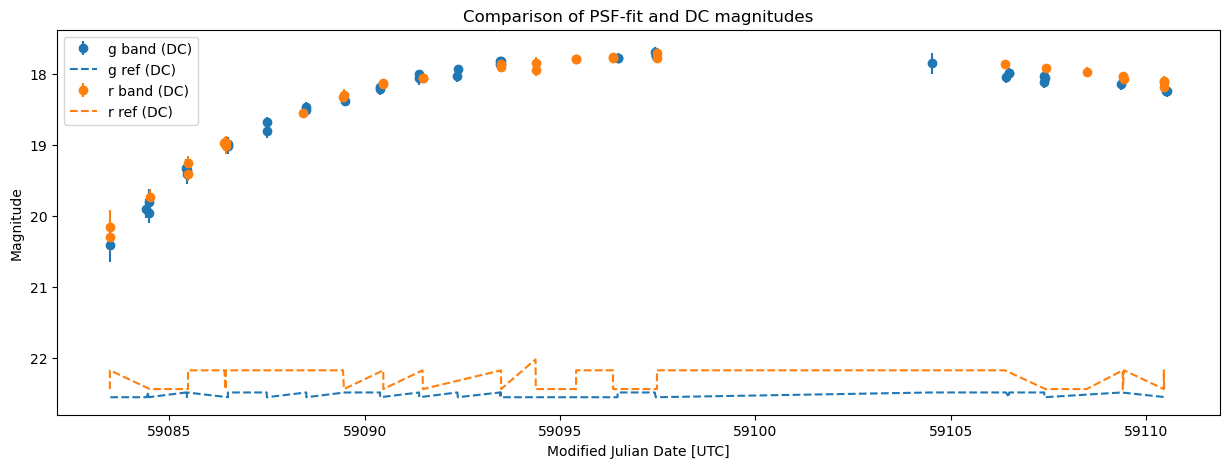

In [19]:
fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(df_valid['fid']):
    maskFilt = df_valid['fid'] == filt

#     plt.errorbar(
#         df_valid[maskFilt]['jd'].apply(lambda x: x - 2400000.5),
#         df_valid[maskFilt]['magpsf'],
#         df_valid[maskFilt]['sigmapsf'],
#         ls = '', marker='s', 
#         color=colordic[filt], 
#         label='{} band (PSF-fit)'.format(filtdic[filt]),
#     )
    
    
    plt.errorbar(
        df_valid[maskFilt]['jd'].apply(lambda x: x - 2400000.5),
        df_valid[maskFilt]['mag_dc'],
        df_valid[maskFilt]['err_dc'],
        ls = '', marker='o', 
        color=colordic[filt], 
        label='{} band (DC)'.format(filtdic[filt]),
    )
    #To show if there is a variance in the reference( magnitude of the nearest source in the reference image PSF)
    plt.errorbar(
        df_valid[maskFilt]['jd'].apply(lambda x: x - 2400000.5),
        df_valid[maskFilt]['magnr'],
        ls = '--', 
        color=colordic[filt], 
        label='{} ref (DC)'.format(filtdic[filt]),
    )
    
# plt.ylim(10,20)

#  Average Values (Used in Fink)
#plt.axhline(y=ref_value_r, color=colordic[2], linestyle='--')
#plt.axhline(y=ref_value_g, color=colordic[1], linestyle='--')
plt.gca().invert_yaxis()
plt.legend()
plt.title('Comparison of PSF-fit and DC magnitudes')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Magnitude');

# 

# 

# 

# 6) Data missing 


Our objective here is to retrieve the missing data values, particularly for cases where they represent upper limits.

In [20]:
# Take only Upper limits data
maskUpper = pd.isna(df['magpsf'])
df_Upper = df[maskUpper].sort_values('jd')

#### Convert 'mjd' to integer to remove fractional part


In [21]:
df_valid['mjd'] = (df_valid['jd'] - 2400000.5).astype(int)
df_Upper['mjd'] = (df_Upper['jd'] - 2400000.5).astype(int)

In [22]:
min_mjd = int(first_day - 2400000.5) #df_by_days['mjd'].min()
max_mjd = int(last_day  - 2400000.5)

# 

Compute the average of the sigma magnitude values for the nearest sources.

We define a function named `apparent_flux_Upper` to calculate the apparent flux, along with its associated sigma (error), for both the DC flux and NR flux, specifically for data representing upper limits.

In [23]:
df_valid['source'] = 1

In [24]:
first_day, last_day

(2459080.6432407, 2459111.0274074)

In [25]:

is_Source_by_fid = df_valid.groupby(['fid', 'is_Source']).size().unstack(fill_value=0).sort_index()

# # Determine which count is highest
is_Source_by_fid['Highest_bool'] = is_Source_by_fid.idxmax(axis=1)


In [26]:
if len(df_valid[df_valid['fid'] == 1]) ==0 : 
    # if we don't have data for green alerts we drop the green upperlim 
    # Not the best solution but Missing data is better than false data 
    df_Upper.drop(df_Upper[df_Upper['fid'] == 1].index, inplace=True)
    
    # We append two data points with zero values. This aids our algorithm without introducing any risk.
    new_rows = pd.DataFrame({'fid': [1, 1],
                             'mjd': [first_day - 2400000.5, last_day - 2400000.5],#[df_valid['jd'].min(), df_valid['jd'].max()],
                             'dc_flux': [0, 0],
                             'dc_sigflux': [0, 0],
                             'nr_flux' : [0,0],
                             'nr_sigflux':[0,0], 
                             'source': [0,0],
                             'is_Source': [is_Source_by_fid['Highest_bool'].iloc[0],is_Source_by_fid['Highest_bool'].iloc[0]]
                            })

    df_valid = pd.concat([df_valid, new_rows], ignore_index=True)

elif len(df_valid[df_valid['fid'] == 2]) ==0 : 
    df_Upper.drop(df_Upper[df_Upper['fid'] == 2].index, inplace=True)
    
        
    new_rows = pd.DataFrame({'fid': [2, 2],
                             'mjd': [first_day - 2400000.5, last_day - 2400000.5],
                             'dc_flux': [0, 0],
                             'dc_sigflux': [0, 0],
                             'nr_flux' : [0,0],
                             'nr_sigflux':[0,0],
                             'source': [0,0],
                             'is_Source': [is_Source_by_fid['Highest_bool'].iloc[0],is_Source_by_fid['Highest_bool'].iloc[0]]
                             
                           })

    df_valid = pd.concat([df_valid, new_rows], ignore_index=True)

#### Remove the upper limit if a valid data exists on the same day.

In [27]:
def get_interval(target_mjd,fid, min_mjd, max_mjd,df_valid):
    lower_bound = min_mjd
    upper_bound = max_mjd
#     print(lower_bound,upper_bound )
    for index, row in df_valid[df_valid['fid'] == fid].iterrows():
        if row['mjd'] < target_mjd:
            lower_bound = row['mjd']
        else:
            upper_bound = row['mjd']
            break
    return lower_bound,upper_bound 

In [28]:
def get_pos_neg(x,magpsf, magnr): # change the name ! 
    #A = 2 ## here for pos flux, =1/2 for neg 
    if (x == 't') or (x == '1'):
        return magpsf < (magnr+0)
    # maskneg = (df['isdiffpos'] == 'f') | (df['isdiffpos'] == '0')
    return magpsf < (magnr+2.5*np.log10(2))

In [29]:
    
for filt in np.unique(df_valid['fid']):
    print(filt)
    df_fid = df_valid[df_valid['fid'] == filt]
    min_mjd2 = df_fid['mjd'].min()
    max_mjd2 = df_fid['mjd'].max()
    print(min_mjd2,max_mjd2)

    
    for index, row in df_Upper[df_Upper['fid'] == filt][['mjd']].iterrows():
        # If valid data and an upper limit are both present in a given day, 
        # we only consider the valid data, (we drope upperlim)
        if len(df_fid[df_fid['mjd'] == row['mjd']]) > 0 :
            df_Upper.drop(index, inplace=True)
        # elif row['mjd'] < min_mjd2 or row['mjd'] > max_mjd: 
        #     df_Upper.drop(index, inplace=True)

        
        elif row['mjd'] < min_mjd2 : #or row['mjd'] > max_mjd: 
             df_min = df_fid[(df_fid['mjd'] == min_mjd2)]
             idx = df_min['magpsf'].idxmax()
             x = df_min['isdiffpos'].loc[idx]
             magpsf_down, magnr_down = df_min[['magpsf','magnr']].loc[idx]
             if get_pos_neg(x,magpsf_down, magnr_down): 
                 df_Upper.drop(index, inplace=True)

        elif row['mjd'] > max_mjd2 :
             df_max = df_fid[(df_fid['mjd'] == max_mjd2)]
             idx = df_max['magpsf'].idxmax()
             x = df_max['isdiffpos'].loc[idx]
             magpsf_up, magnr_up = df_max[['magpsf','magnr']].loc[idx]
             if get_pos_neg(x,magpsf_up, magnr_up): 
                 df_Upper.drop(index, inplace=True)


        else:
            lower_bound,upper_bound = get_interval(row['mjd'],filt, min_mjd2, max_mjd2, df_valid)
            # print(filt, row['mjd'], lower_bound, upper_bound)
                  
            df_down = df_fid[(df_fid['mjd'] == lower_bound)]
            idx_down = df_down['magpsf'].idxmax()
            x_down = df_down['isdiffpos'].loc[idx_down]
            magnr_down, magpsf_down = df_down[['magnr','magpsf']].loc[idx_down]


            df_up = df_fid[(df_fid['mjd'] == upper_bound)]
            idx_up = df_up['magpsf'].idxmax()
            x_up = df_up['isdiffpos'].loc[idx_up]
            magnr_up, magpsf_up = df_up[['magnr','magpsf']].loc[idx_up]
            
            
            print(filt, row['mjd'], lower_bound, upper_bound, magpsf_down, magpsf_up, magnr_down, magnr_up)
            if get_pos_neg(x_down, magpsf_down, magnr_down) and get_pos_neg(x_up, magpsf_up, magnr_up):
                print("A>1")
                df_Upper.drop(index, inplace=True)


            

1
59083 59110
2
59083 59110


In [30]:
there_upper = (len(df_Upper)>0)
if there_upper:
    
    is_Source_by_fid = df_valid.groupby(['fid', 'is_Source']).size().unstack(fill_value=0).sort_index()

    # # Determine which count is highest
    is_Source_by_fid['Highest_bool'] = is_Source_by_fid.idxmax(axis=1)
    ### if there is no valid data we drop upper limit data (so why do we still modify its mean !)

    
    
    if is_Source_by_fid['Highest_bool'].iloc[0]: 
        mean_sigmnr_g = np.sqrt((df_valid[df_valid['fid'] == 1]['sigmagnr'] ** 2).mean())
    else:
        ref_value_g = np.inf
        mean_sigmnr_g = 0

        
    if is_Source_by_fid['Highest_bool'].iloc[1]: 
        mean_sigmnr_r = np.sqrt((df_valid[df_valid['fid'] == 2]['sigmagnr'] ** 2).mean())
    else:
        ref_value_r = np.inf
        mean_sigmnr_r = 0
                
        
    
    from FAnomAly.flux import apparent_flux_Upper

    dc_flux, dc_sigflux,nr_sigflux = np.transpose(
        [
            apparent_flux_Upper(*args, ref_value_r, ref_value_g, mean_sigmnr_r, mean_sigmnr_g, jansky=True) for args in zip(
                df_Upper['diffmaglim'].astype(float).values,
                df_Upper['fid'].astype(int).values,

            )  
        ]
     )

    df_Upper['dc_flux'] = dc_flux
    df_Upper['dc_sigflux'] = dc_sigflux
    df_Upper['nr_sigflux'] = nr_sigflux
    df_Upper['nr_flux'] = dc_flux

### Plot the apparent DC flux (in millijansky) for both valid and upper limits data.

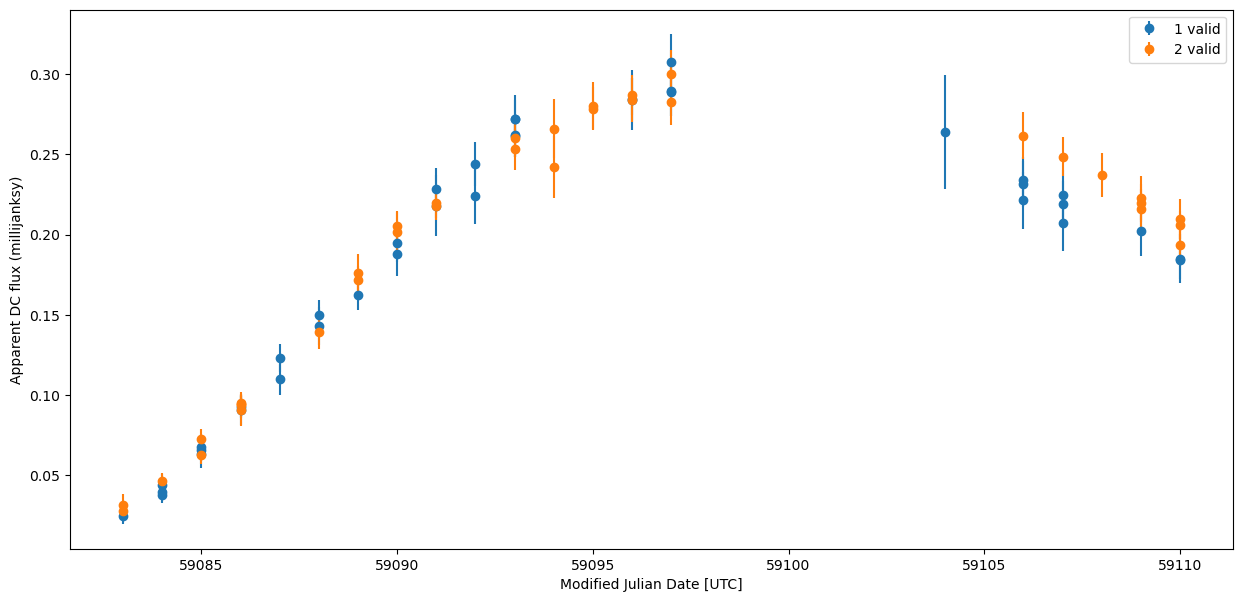

In [31]:
fig = plt.figure(figsize=(15, 7))


for filt in np.unique(df['fid']):
    mask = df_valid['fid'] == filt
    sub = df_valid[mask]
    plt.errorbar(
        sub['mjd'],#.apply(lambda x: x - 2400000.5),
        sub['dc_flux']*1e3, 
        sub['dc_sigflux']*1e3,
        ls='', 
        marker='o',
        color=colordic[filt], 

        label=f"{filt} valid"
    )
    
    if there_upper:
        mask2 = df_Upper['fid'] == filt
        plt.errorbar(
        df_Upper[mask2]['mjd'],#.apply(lambda x: x - 2400000.5),
        df_Upper[mask2]['dc_flux']*1e3,
        df_Upper[mask2]['dc_sigflux']*1e3,
        ls='', 
        marker='.',
        color=colordic[filt], 

        label=f"{filt} Upperlim"
        )
#     break
        
plt.legend()

plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Apparent DC flux (millijanksy)');

In [32]:
df_Upper[df_Upper['fid'] == 2]

,aimage,aimagerat,bimage,bimagerat,candid,chinr,chipsf,classtar,clrcoeff,clrcounc,...,sigmapsf,sky,ssdistnr,ssmagnr,ssnamenr,sumrat,tblid,xpos,ypos,mjd


# 

# 

# 7) Combine Upper with valid 

We merge the data from the upper limit and valid datasets based on specific columns.

In [33]:
df_valid['is_valid'] = True
df_Upper['is_valid'] = False

In [34]:
columns_to_keep = ['mjd', 'fid','dc_flux', 'dc_sigflux', 'nr_flux', 'nr_sigflux','source','is_valid']
if there_upper: 
    df_Upper['source'] = 1
    combined_df = pd.concat([df_Upper[columns_to_keep], df_valid[columns_to_keep]], axis=0)
else:
    combined_df = df_valid[columns_to_keep].copy()

In [35]:
combined_df.sort_index(inplace=True)

In [36]:
combined_df.head(2)

,mjd,fid,dc_flux,dc_sigflux,nr_flux,nr_sigflux,source,is_valid
8,59083,2,0.000028,0.000005,0.000004,6.939978e-07,1,True
9,59083,2,0.000032,0.000007,0.000005,1.092741e-06,1,True


# 

# 

# 8) Data by days 

Here, we group the data by modified Julian date on a daily basis and by filter ID (1 for g, 2 for R, 3 for i), computing the average values of flux and sigma flux(for both DC and NR) using the `Weighted_Mean` functions.

In [37]:
# combined_df.loc[:, 'mjd'] = (combined_df['jd'] - 2400000.5).astype(int)

#### group the data by mjd and by filter

In [38]:
df_group = combined_df.groupby(['mjd','fid'])

#### calculate the average values

In [39]:
from FAnomAly.Weighted_Mean import Weighted_Mean_general

df_by_days = pd.DataFrame()
df_by_days = df_group.apply(Weighted_Mean_general, flux_col='dc_flux', sigflux_col='dc_sigflux')

In [40]:
df_by_days[['nr_flux', 'nr_sigflux']] = df_group.apply(Weighted_Mean_general, flux_col='nr_flux',sigflux_col='nr_sigflux')

We extract the initial value from the 'source' column within each group. It's noteworthy that on any given day (represented by 'r/g'), there might be either missing data or available data.

In [41]:
df_by_days['source'] = df_group.apply(lambda group: group['source'].iloc[0])
df_by_days['is_valid'] = df_group.apply(lambda group: group['is_valid'].iloc[0])

In [42]:
# Only once !...
df_by_days.reset_index(inplace=True)

In [43]:
df_by_days#.tail(2)

,mjd,fid,dc_flux,dc_sigflux,nr_flux,nr_sigflux,source,is_valid
0,59083,1,0.000025,0.000005,0.000003,5.414409e-07,1,True
1,59083,2,0.000029,0.000004,0.000004,5.858348e-07,1,True
2,59084,1,0.000040,0.000003,0.000003,3.591450e-07,1,True
3,59084,2,0.000047,0.000004,0.000004,6.939978e-07,1,True
4,59085,1,0.000066,0.000004,0.000004,4.355124e-07,1,True
5,59085,2,0.000067,0.000005,0.000004,5.858348e-07,1,True
6,59086,1,0.000092,0.000006,0.000004,4.799210e-07,1,True
7,59086,2,0.000094,0.000004,0.000004,4.142478e-07,1,True
8,59087,1,0.000117,0.000007,0.000004,4.799210e-07,1,True
9,59088,1,0.000147,0.000007,0.000004,4.799210e-07,1,True


# 

# 

# 9) Fill the missing days ! 

If there are missing days without alerts in the data, we can fill these gaps by inserting average values.

In [44]:
from FAnomAly.Weighted_Mean import Weighted_Mean_all

min_mjd = int(first_day - 2400000.5) #df_by_days['mjd'].min()
max_mjd = int(last_day  - 2400000.5) #df_by_days['mjd'].max()
# Create a DataFrame all_days containing a range of MJD values from the minimum to the maximum MJD found in df_by_days.
all_days = pd.DataFrame({'mjd': range(min_mjd, max_mjd + 1)}) # + 1 i need to check this one ! 

df_extended = df_by_days
# df_extended['source'] = 1 # I need to check for this one


there_missing_data = (df_by_days.shape[0] < (max_mjd -min_mjd +1)*2)
if there_missing_data:        
     for filt in np.unique(df_extended['fid']):
        print(filt)
        mask = df_extended['fid'] == filt
        sub = df_extended[mask]
        data_days = df_extended[mask]['mjd']

        missing_days = all_days[~all_days['mjd'].isin(data_days)]
    
    
        df_predic = pd.DataFrame(index=missing_days['mjd'])
    
        dc_flux ,nr_flux = Weighted_Mean_all(sub)
        
        dc_sigflux = sub['dc_flux'].std()
        nr_sigflux = sub['nr_flux'].std()
        
        #print(dc_flux*1e3, dc_sigflux*1e3 ,nr_flux*1e3 ,nr_sigflux*1e3)

        
        df_predic[['fid','dc_flux', 'dc_sigflux' ,'nr_flux' ,'nr_sigflux']] = [filt,dc_flux, dc_sigflux ,nr_flux ,nr_sigflux]
        df_predic['source'] = 0

        # Add a new column 'source' to df_extended

        df_extended = pd.concat([df_extended, df_predic.reset_index()], ignore_index=True)
        

1
2


In [45]:
df_predic

,fid,dc_flux,dc_sigflux,nr_flux,nr_sigflux,source
mjd,,,,,,
59080,2,0.000135,0.000085,0.000004,2.955996e-07,0
59081,2,0.000135,0.000085,0.000004,2.955996e-07,0
59082,2,0.000135,0.000085,0.000004,2.955996e-07,0
59087,2,0.000135,0.000085,0.000004,2.955996e-07,0
59092,2,0.000135,0.000085,0.000004,2.955996e-07,0
59098,2,0.000135,0.000085,0.000004,2.955996e-07,0
59099,2,0.000135,0.000085,0.000004,2.955996e-07,0
59100,2,0.000135,0.000085,0.000004,2.955996e-07,0
59101,2,0.000135,0.000085,0.000004,2.955996e-07,0


In [46]:
df_extended.sort_values(by=['mjd','fid'],   inplace=True)
df_extended.reset_index(drop= True, inplace=True)

In [47]:
df_extended.head(2)

,mjd,fid,dc_flux,dc_sigflux,nr_flux,nr_sigflux,source,is_valid
0,59080,1,0.000119,0.000083,0.000004,7.169161e-08,0,NaN
1,59080,2,0.000135,0.000085,0.000004,2.955996e-07,0,NaN


In [48]:
df_extended.shape

(62, 8)

### plot apparent  DC and nr flux in millijanksy 

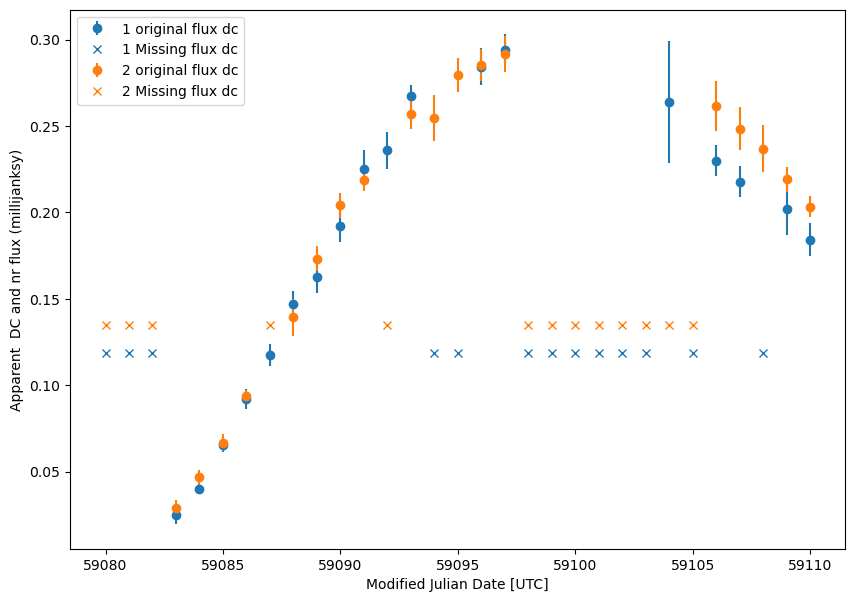

In [49]:
fig = plt.figure(figsize=(10, 7))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}


for filt in np.unique(df_extended['fid']):
    mask = df_extended['fid'] == filt
    mask_missing =  df_extended['source'] == 0
    mask_original = df_extended['source'] == 1
    sub2 = df_extended[mask & mask_missing]
    sub = df_extended[mask & mask_original]
    
    plt.errorbar(
        sub['mjd'],
        sub['dc_flux']*1e3, 
        sub['dc_sigflux']*1e3,
        ls='', 
        marker='o',
        color=colordic[filt], 

        label=f"{filt} original flux dc"
    )
    plt.errorbar(
        sub2['mjd'],
        sub2['dc_flux']*1e3, 
#         sub2['dc_sigflux']*1e3,
        ls='', 
        marker='x',
        color=colordic[filt], 

        label=f"{filt} Missing flux dc"
    )
    
    

    """plt.errorbar(
        df[mask]['mjd'],
        df[mask]['nr_flux']*1e3,
        df[mask]['nr_sigflux']*1e3,
        ls='', 
        marker='.',
        color=colordic[filt], 

        label=f"{filt} all nr"
    )"""
    
    
    
plt.legend()

plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Apparent  DC and nr flux (millijanksy)');

In [50]:
len(df_extended['dc_flux'])

62

In [ ]:
test = df_extended['dc_flux'][::2].values/df_extended['dc_flux'][1::2].values
test

In [ ]:
test[10]

In [ ]:
fig = plt.figure(figsize=(15, 7))


for filt in np.unique(df_by_days['fid']):
    mask = df_by_days['fid'] == filt
    sub = df_by_days
    plt.errorbar(
        sub[mask]['mjd'],
        sub[mask]['dc_flux']*1e3, 
        sub[mask]['dc_sigflux']*1e3,
        ls='', 
        marker='o',
        color=colordic[filt], 

        label=f"{filt} all flux dc"
    )
    

    """plt.errorbar(
        df[mask]['mjd'],
        df[mask]['nr_flux']*1e3,
        df[mask]['nr_sigflux']*1e3,
        ls='', 
        marker='.',
        color=colordic[filt], 

        label=f"{filt} all nr"
    )"""
    
    
    
plt.legend()

plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Apparent  DC and nr flux (millijanksy)');

# 

# 

# 10) Create a final dataframe to consolidate the values of this alert into a single row.

In this dataframe, include another dataframe as a dictionary containing the values of mjd,flux, sigma, and so on.

In [ ]:
df_anomaly = pd.DataFrame()
df_anomaly['objectId'] = [pdf_last_alert.objectId]
df_anomaly['candid'] = [pdf_last_alert.candid]
df_anomaly['jd'] = [pdf_last_alert.candidate['jd']]
df_anomaly['df'] = [df_extended.to_dict()]

In [ ]:
df_anomaly

In [ ]:
#Here's an example of how we can utilize the dataframe of the first row:
df_test = pd.DataFrame.from_dict(df_anomaly['df'].iloc[0])

In [ ]:
df_test.head(4)

# 

# 